In [1]:
dataset_name = "W16_comb"
df_list = [
           "BES_Panel",
#            "BES_reduced_with_na",
#            "BESnumeric"
#            "BES_reduced",
#            "BESnumeric"
          ]

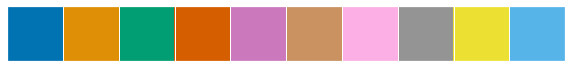

In [2]:
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import pickle, os, gc, re
sns.set()
sns.palplot(sns.color_palette("colorblind"))
from IPython.display import display, display_html, HTML
plt.rcParams["axes.grid"] = False

import Jupyter_module_loader
from utility import *
import gaussian_kde


In [3]:
# you should clone this git to a subdirectory called 'BES_analysis_code' (in some directory - I call it BES_analysis - doesn't matter though)
# %matplotlib inline
encoding = "ISO-8859-1"

(BES_code_folder, BES_small_data_files, BES_data_folder,
 BES_output_folder, BES_file_manifest, BES_R_data_files) = setup_directories()



In [4]:
global BES_Panel, BES_numeric, BES_reduced, BES_reduced_with_na, BES_non_numeric
data_subfolder = BES_data_folder + dataset_name + os.sep

(manifest, dataset_filename, dataset_description, dataset_citation,
 dataset_start, dataset_stop, dataset_wave) = get_manifest(dataset_name, BES_file_manifest)

for df in df_list:
    if df=="BES_Panel":
        globals()[df]  = pd.read_msgpack(data_subfolder + dataset_filename.replace('.dta','.msgpack'))
    else:
        globals()[df]  = pd.read_msgpack(data_subfolder + df + '.msgpack' )
        globals()[df].replace(-1,np.nan,inplace=True)
  
# (var_type, cat_dictionary, new_old_col_names, old_new_col_names) = get_small_files(data_subfolder, encoding)

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\IPython\core\interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
pan_dataset_allr_values = pd.read_csv(BES_small_data_files + "pan_dataset_allr_values"+".csv")

In [6]:
global best_weight_series
def weighted_mean(series):
    return (series*best_weight_series.loc[series.index]).sum()/(best_weight_series.loc[series.index]).sum()


In [7]:
BES_census_data = pd.read_stata( BES_small_data_files + "BES-2017-General-Election-results-file-v1.0.dta" )
print("BES_census_data", BES_census_data.shape )

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\pandas\io\stata.py:1453: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  warnings.warn(msg.format(encoding=self._encoding), UnicodeWarning)


BES_census_data (632, 308)


In [9]:
BES_census_data.columns

Index(['pano', 'ONSConstID', 'ConstituencyName', 'Country', 'Region',
       'ConstituencyType', 'Winner17', 'Con17', 'Lab17', 'LD17',
       ...
       'c11HealthBad', 'c11HealthVeryBad', 'c11NoAdultsEmployed',
       'c11NoAdultsEmployedChildren', 'c11NoAdultsEmployedNoChildren',
       'c11DeprivedNone', 'c11Deprived1', 'c11Deprived2', 'c11Deprived3',
       'c11Deprived4'],
      dtype='object', length=308)

In [10]:
BES_census_data.dtypes.value_counts()

float64     250
object       18
category     14
int32        10
category      7
int16         3
category      2
category      1
category      1
category      1
category      1
dtype: int64

In [11]:
BES_census_data.columns[BES_census_data.dtypes=='category']
# Country: category (England/Scotland/Wales)
# Region: category (gor)
# ConstituencyType: category County|Borough
# <party categories>: 'Winner17', 'Winner15', 'Winner10',
# Male|Female <party>PPCsex<15|17>
# White|BME <party>PPCrace<15|17>


Index(['Country', 'Region', 'ConstituencyType', 'Winner17', 'Winner15',
       'Winner10', 'ConPPCsex17', 'LabPPCsex17', 'LDPPCsex17', 'SNPPPCsex17',
       'PCPPCsex17', 'UKIPPPCsex17', 'GreenPPCsex17', 'ConPPCsex15',
       'ConPPCrace15', 'LabPPCsex15', 'LabPPCrace15', 'LDPPCsex15',
       'LDPPCrace15', 'SNPPPCsex15', 'SNPPPCrace15', 'PCPPCsex15',
       'PCPPCrace15', 'UKIPPPCsex15', 'UKIPPPCrace15', 'GreenPPCsex15',
       'GreenPPCrace15'],
      dtype='object')

White    569
BME       62
Name: ConPPCrace15, dtype: int64

In [112]:
# BES_census_data.columns[BES_census_data.dtypes=='int16']
# 'RejectedVote17', 'RejectedVote15'
# pano = constId

c11_vars = [x for x in BES_census_data.columns[BES_census_data.dtypes=='float'] if "c11" in x]
nonc11vars = [x for x in BES_census_data.columns[BES_census_data.dtypes=='float'] if "c11" not in x]

num_non_perc_vars = ['RejectedVote17', 'RejectedVote15']
num_non_perc_vars.extend(list(BES_census_data.columns[BES_census_data.dtypes=='int32']))
num_non_perc_vars.append('c11PopulationDensity')

percentage_vars = c11_vars
percentage_vars.remove('c11PopulationDensity')

percentage_vars.extend( list(BES_census_data[nonc11vars].columns[ BES_census_data[nonc11vars].max()<=100 ]) )

num_non_perc_vars.extend( list(BES_census_data[nonc11vars].columns[ BES_census_data[nonc11vars].max()>100 ]) )

id_vars = ["pano","ONSConstID","ConstituencyName"]
name_vars = [x for x in BES_census_data.columns if re.search("PPC(17|15)",x)]

In [113]:
BES_census_data[["SeatChange1517","SeatChange1015"]] = BES_census_data[["SeatChange1517","SeatChange1015"]].replace(" ",np.nan).astype('category')

categorical_vars = list( BES_census_data.columns[BES_census_data.dtypes=='category'] )
categorical_vars.extend(["SeatChange1517","SeatChange1015"])


df = pd.concat([ pd.get_dummies(BES_census_data[categorical_vars]),
                 BES_census_data[ percentage_vars+num_non_perc_vars ] ], axis=1).astype('float')

In [114]:
df

,Country_England,Country_Scotland,Country_Wales,Region_North East,Region_North West,Region_Yorkshire and The Humber,Region_East Midlands,Region_West Midlands,Region_East of England,Region_London,...,UKIPVote15,GreenVote15,BNPVote15,LabVote10,LDVote10,SNPVote10,PCVote10,UKIPVote10,GreenVote10,BNPVote10
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4971.0,711.0,NaN,16073.0,5034.0,NaN,2198.0,489.0,NaN,1276.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3467.0,727.0,NaN,7336.0,5786.0,NaN,5341.0,632.0,NaN,NaN
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,16746.0,7001.0,8385.0,NaN,NaN,NaN,635.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,897.0,964.0,NaN,15722.0,12216.0,5102.0,NaN,NaN,413.0,529.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1006.0,885.0,NaN,6159.0,17362.0,7086.0,NaN,397.0,NaN,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
627,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7646.0,2191.0,NaN,2991.0,31843.0,NaN,NaN,2357.0,NaN,1162.0
628,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5121.0,NaN,NaN,11490.0,2592.0,NaN,9029.0,1201.0,NaN,NaN
629,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,4795.0,4791.0,NaN,18573.0,11694.0,NaN,NaN,1100.0,1669.0,1171.0
630,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,5251.0,2558.0,NaN,9108.0,19224.0,NaN,NaN,1100.0,NaN,956.0


In [14]:
BES_census_data.columns[BES_census_data.dtypes=='object']
# ONSConstID: ONS area code
# ConstituencyName: ... Const name
# SeatChange1517,SeatChange1015: categorical!
# Names:
#        'ConPPC17', 'LabPPC17', 'LDPPC17', 'SNPPPC17', 'PCPPC17', 'UKIPPPC17',
#        'GreenPPC17', 'ConPPC15', 'LabPPC15', 'LDPPC15', 'SNPPPC15', 'PCPPC15',
#        'UKIPPPC15', 'GreenPPC15'

Index(['ONSConstID', 'ConstituencyName', 'SeatChange1517', 'SeatChange1015',
       'ConPPC17', 'LabPPC17', 'LDPPC17', 'SNPPPC17', 'PCPPC17', 'UKIPPPC17',
       'GreenPPC17', 'ConPPC15', 'LabPPC15', 'LDPPC15', 'SNPPPC15', 'PCPPC15',
       'UKIPPPC15', 'GreenPPC15'],
      dtype='object')

In [98]:


# all aggregate %s

# c11PassportAny ... goes up to 103%!
# c11PopulationDensity ... absolute value, not %


In [103]:
BES_census_data[nonc11vars].columns[ BES_census_data[nonc11vars].max()<=100 ]

Index(['Con17', 'Lab17', 'LD17', 'SNP17', 'PC17', 'UKIP17', 'Green17',
       'Other17', 'Majority17', 'Turnout17', 'Con1517', 'Lab1517', 'LD1517',
       'SNP1517', 'PC1517', 'UKIP1517', 'Green1517', 'Con15', 'Lab15', 'LD15',
       'SNP15', 'PC15', 'UKIP15', 'Green15', 'Other15', 'Majority15',
       'Turnout15', 'Con1015', 'Lab1015', 'LD1015', 'SNP1015', 'PC1015',
       'UKIP1015', 'Green1015', 'Con10', 'Lab10', 'LD10', 'SNP10', 'PC10',
       'UKIP10', 'Green10', 'BNP10', 'Majority10', 'Turn10', 'leaveHanretty',
       'remainHanretty'],
      dtype='object')

In [105]:
BES_census_data[nonc11vars].columns[ BES_census_data[nonc11vars].max()>100 ]

Index(['LabVote17', 'LDVote17', 'SNPVote17', 'PCVote17', 'UKIPVote17',
       'GreenVote17', 'LabVote15', 'LDVote15', 'SNPVote15', 'PCVote15',
       'UKIPVote15', 'GreenVote15', 'BNPVote15', 'LabVote10', 'LDVote10',
       'SNPVote10', 'PCVote10', 'UKIPVote10', 'GreenVote10', 'BNPVote10'],
      dtype='object')

In [102]:
BES_census_data['Con17']

0      17.737766
1      44.594090
2      22.692276
3      42.132470
4      47.852785
         ...    
627    54.489597
628    27.789226
629    30.174427
630    51.118812
631    58.273408
Name: Con17, Length: 632, dtype: float64

In [ ]:
# pano

In [128]:
df.isnull().sum(axis=0).sort_values(ascending=False).head(100)

BNPVote15              624
PC1517                 592
PC17                   592
PC15                   592
PC1015                 592
                      ... 
GreenPPCsex15_Woman      0
GreenPPCsex15_Man        0
UKIPPPCrace15_BME        0
UKIPPPCrace15_White      0
UKIPPPCsex15_Woman       0
Length: 100, dtype: int64

In [155]:
df.mean().index

Index(['Country_England', 'Country_Scotland', 'Country_Wales',
       'Region_North East', 'Region_North West',
       'Region_Yorkshire and The Humber', 'Region_East Midlands',
       'Region_West Midlands', 'Region_East of England', 'Region_London',
       ...
       'UKIPVote15', 'GreenVote15', 'BNPVote15', 'LabVote10', 'LDVote10',
       'SNPVote10', 'PCVote10', 'UKIPVote10', 'GreenVote10', 'BNPVote10'],
      dtype='object', length=376)

In [165]:
df.columns[df.mean()<0]

Index(['LD1517', 'SNP1517', 'PC1517', 'UKIP1517', 'Green1517', 'LD1015'], dtype='object')

In [169]:
df = df.apply(lambda x: x.fillna(x.mean()))

In [173]:
## Lets try some PCA!


Treatment = "census_PCA"

output_subfolder = BES_output_folder + Treatment + os.sep
if not os.path.exists( output_subfolder ):
    os.makedirs( output_subfolder )

In [174]:
df_cols = df.columns
df_ind = df.index

# normalise data (subtract out the mean, divide through by standard deviation)
clean_feature_set_std = StandardScaler().fit_transform(df.values )
BES_std = pd.DataFrame(      clean_feature_set_std,
                             columns = df_cols,
                             index   = df_ind      )

In [175]:
%%time
# 5 mins
## RUN (some variant of) PCA (potentially v slow!)
n_components = BES_std.shape[1]
n_components = 2
# (svd_solver='full', n_components='mle',whiten=True)
# decomp = PCA(n_components = n_components,svd_solver='full')
# decomp = FastICA(algorithm='deflation', fun='exp', fun_args=None, max_iter=1000,
#     n_components=None, random_state=None, tol=0.07, w_init=None, whiten=False) # 2h 1min 4s "fast"
# decomp = SparsePCA(n_components=n_components, alpha=2,max_iter=1000,n_jobs=4,tol=1e-10, verbose=True) # 5min
#
# alpha=2 -> 1hr

decomp = FactorAnalysis(svd_method = 'lapack',n_components = n_components) ## ~10s ,n_components=30 -> 1.5 hrs
decomp_method = str(decomp).split("(")[0] 
# ,n_components=30

X_r = decomp.fit_transform(BES_std)

BES_decomp = pd.DataFrame(   X_r,
                             columns = range(0,n_components),
                             index   = df_ind)

Wall time: 867 ms


In [179]:
# treatdir = BES_data_folder+Treatment
# subdir = BES_data_folder+Treatment+decomp_method
load_suff = "FactorAnalysis"
save = True # False => Load

if save & ( 'decomp' in globals() ): # SAVE    ##( 'decomp' not in globals() )
    decomp_method = str(decomp).split("(")[0] 
    subdir = output_subfolder + decomp_method
    fname = subdir+ os.sep + decomp_method
    # create dir, save decomp object, BES_decomp, BES_std    
    if not os.path.exists(subdir): os.makedirs(subdir)
    with open(fname+".pkl", "wb") as f: pickle.dump( decomp, f )
    BES_decomp.to_msgpack(fname+".msgpack"     )
    BES_std.to_msgpack(   fname+"_std"+".msgpack" )
    
else: # LOAD decomp results (default is SAVE)
    decomp_method = load_suff
    subdir = output_subfolder + os.sep + decomp_method    
    fname = subdir + os.sep + decomp_method
    if not os.path.exists(subdir): raise Exception(subdir + ' does not exist!')
    # load decomp object, BES_decomp, BES_std, n_components
    with open(fname+".pkl", "rb") as f: decomp = pickle.load(f) 
    BES_decomp = pd.read_hdf(fname+".hdf")
    BES_std    = pd.read_hdf(fname+"_std"+".hdf")
    n_components = decomp.components_.shape[0] 

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  del sys.path[0]
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  


average log-likelihood of all samples: -438.58861250805046
number of iterations: 10


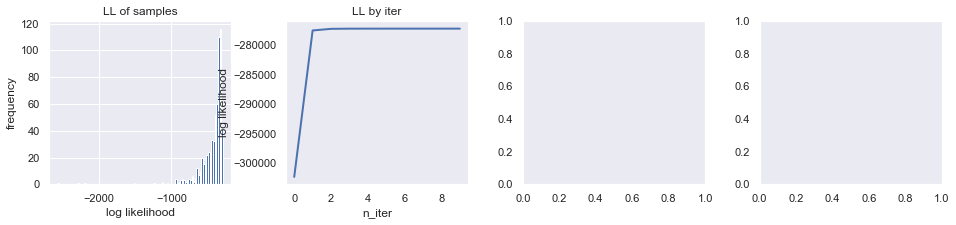

In [180]:
display_pca_data(n_components, decomp, BES_std)

Warning, filename truncated because it was over 30. Filenames may no longer be unique


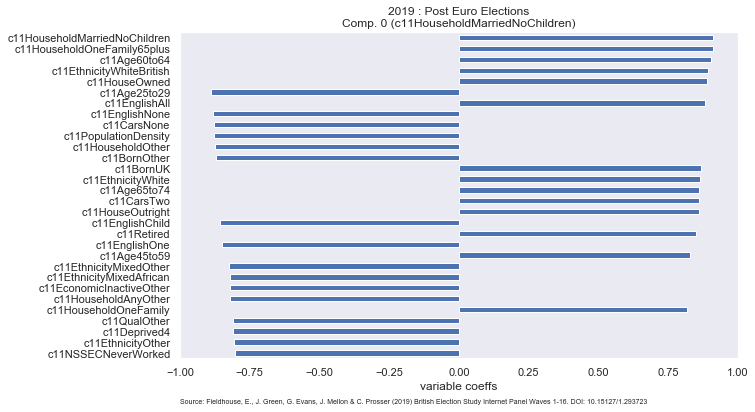

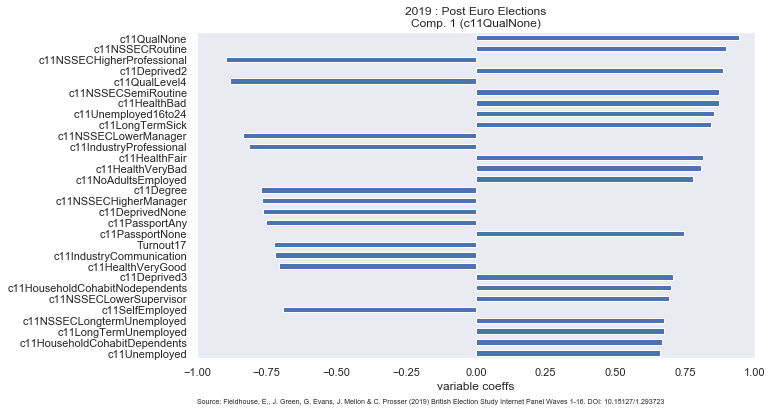

In [181]:
(BES_decomp, comp_labels, comp_dict) = display_components(n_components, decomp,
                                                          df_cols, BES_decomp, manifest, 
                                                          save_folder = subdir,  
                                                          show_first_x_comps= 4, show_histogram = False)